# Импорт библиотек

In [47]:
# Загружаем библиотеки
!pip install rdkit
!pip install pubchempy
import numpy as np
import pandas as pd
import pubchempy as pcp
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem 
from rdkit.Chem import Descriptors


# Работа с датасетом

#### Объявляем функции

In [4]:
# Чистка датасета: удаляем дубликаты, фильтруем по двухкомп. системам (так как трёхкомпонентных мало и у них не указан тип DES) и
# по плотности < 2, убираем ненужные столбцы
def dataset_clear(dataset):
    dataset = dataset.drop_duplicates(subset=['Component#1', 'Component#2', 
                                    'X#1 (molar fraction)', 'X#2 (molar fraction)', 
                                    'Temperature, K', 'Density, g/cm^3'])
    dataset = dataset[(dataset['Number of components'] == 2) & (dataset['Density, g/cm^3'] <= 2.0)]
    dataset = dataset.drop(['Number of components', 'Reference (DOI)', 'X#3 (molar fraction)', 'Component#3', 'II'], axis=1)
    return dataset

In [5]:
# Выгружаем SMILES из PubChem и добавляем их в датасет
def get_smiles(dataset):

    replace_mapper = {'Octyl Paraben': 'octylparaben'} #Некорректное название, поменяем на правильное
    dataset.replace(replace_mapper, inplace=True)

    # Создаём список уникальных названий молекул
    dataset_unique_1 = list(dataset['Component#1'].unique())
    dataset_unique_2 = list(dataset['Component#2'].unique())
    dataset_unique_1.extend(dataset_unique_2)
    dataset_unique = list(set(dataset_unique_1))

    smiles_dict = {}

    for compound in dataset_unique:
        compounds = pcp.get_compounds(compound, 'name')
        
        # Делаем проверку, что соединение есть в базе
        try:
            mol = compounds[0]
            smiles_dict[compound] = mol.canonical_smiles
        except:
            print(f'Соединение c названием {compound} не найдено.')

    dataset['SMILES#1'] = dataset['Component#1'].map(smiles_dict)
    dataset['SMILES#2'] = dataset['Component#2'].map(smiles_dict)
    
    return dataset

In [6]:
# Добавляем дескрипторы из RDKit
def get_descriptors_values(descriptors_list, dataset):
    
    # Создаём лист уникальных SMILES
    smiles_unique_1 = list(dataset['SMILES#1'].unique())
    smiles_unique_2 = list(dataset['SMILES#2'].unique())
    smiles_unique_1.extend(smiles_unique_2)
    smiles_unique = list(set(smiles_unique_1))

    descriptors_dict = {}

    for smiles in smiles_unique:
        # Тест, что для SMILES доступны дескрипторы rdkit
        try:
            molecule = Chem.MolFromSmiles(smiles)
            descriptors_dict[smiles] = [Descriptors.CalcMolDescriptors(molecule)[descriptor] for descriptor in descriptors_list]
        except:
            print(f'Соединение cо SMILES {smiles} не найдено.')

    # Получаем словарь SMILES: [descriptor1, descriptor2, ...]
    return descriptors_dict

In [7]:
# Добавляем дескрипторы rdkit в датасет
def merge_descriptors(descriptors_dict, descriptors_list, dataset):
    
    # Создаём названия для столбцов
    column_list_1 = [i + '#1' for i in descriptors_list]
    column_list_2 = [i + '#2' for i in descriptors_list]

    for i in range(len(descriptors_list)):
        dataset[column_list_1[i]] = dataset['SMILES#1'].map(lambda x: descriptors_dict.get(x)[i])

    for i in range(len(descriptors_list)):
        dataset[column_list_2[i]] = dataset['SMILES#2'].map(lambda x: descriptors_dict.get(x)[i])
        
    return dataset

#### Подготовка датасета

In [8]:
dataset = pd.read_csv(df.drop(['Unnamed: 0', ], axis=1, inplace=True))
dataset.head(5)

,Number of components,Type of DES,I,II,III,IV,V,Component#1,Component#2,Component#3,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3",Reference (DOI)
0,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,NaN,0.500,0.500,NaN,300.20,1.10250,10.1016/j.cclet.2013.09.004
1,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.500,0.500,NaN,303.15,1.50913,10.1016/j.jobe.2021.103056
2,2,Ⅰ,1,0,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,NaN,0.333,0.667,NaN,303.15,1.34292,10.1016/j.jobe.2021.103056
3,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,293.00,1.19500,10.1016/j.cep.2015.04.001
4,2,Ⅰ,1,0,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,NaN,0.333,0.667,NaN,303.00,1.18800,10.1016/j.cep.2015.04.001


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4309 entries, 0 to 4308
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Number of components  4309 non-null   int64  
 1   Type of DES           3984 non-null   object 
 2   I                     4309 non-null   int64  
 3   II                    4309 non-null   int64  
 4   III                   4309 non-null   int64  
 5   IV                    4309 non-null   int64  
 6   V                     4309 non-null   int64  
 7   Component#1           4309 non-null   object 
 8   Component#2           4309 non-null   object 
 9   Component#3           325 non-null    object 
 10  X#1 (molar fraction)  4309 non-null   float64
 11  X#2 (molar fraction)  4309 non-null   float64
 12  X#3 (molar fraction)  325 non-null    float64
 13  Temperature, K        4309 non-null   float64
 14  Density, g/cm^3       4309 non-null   float64
 15  Reference (DOI)      

In [10]:
dataset.describe()

,Number of components,I,II,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),X#3 (molar fraction),"Temperature, K","Density, g/cm^3"
count,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,4309.000000,325.000000,4309.000000,4309.000000
mean,2.075424,0.013692,0.000464,0.655372,0.071942,0.337897,0.340917,0.641705,0.224315,320.035424,42.854478
std,0.264104,0.116224,0.021542,0.475302,0.258423,0.473048,0.190665,0.197232,0.262686,20.757705,1201.130102
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034000,0.078000,0.016393,278.150000,0.806000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,0.041683,303.150000,1.000612
50%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.333000,0.667000,0.062500,318.150000,1.090300
75%,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.800000,0.333333,333.150000,1.185486
max,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.917000,0.950000,0.843000,413.150000,44562.000000


In [11]:
# Чистим датасет
pre_dataset = dataset_clear(dataset)

In [12]:
# SMILES
pre_dataset = get_smiles(pre_dataset)

In [13]:
# Объявляем дескрипторы из rdkit, добавляем их в датасет
descriptors_list = ['MolLogP', 'NumHeteroatoms', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'TPSA', 'MolWt']

descriptors_dict = get_descriptors_values(descriptors_list, pre_dataset)
final_dataset = merge_descriptors(descriptors_dict, descriptors_list, pre_dataset)
final_dataset.head(5)

,Type of DES,I,III,IV,V,Component#1,Component#2,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K",...,TPSA#1,MolWt#1,MolLogP#2,NumHeteroatoms#2,NumAromaticRings#2,NumHAcceptors#2,NumHDonors#2,NumRotatableBonds#2,TPSA#2,MolWt#2
0,Ⅰ,1,0,0,0,Zincchloride,1-Butyl-3-methyl imidazolium chloride,0.500,0.500,300.20,...,0.0,136.296,-1.8833,3,1,1,0,3,8.81,174.675
1,Ⅰ,1,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,0.500,0.500,303.15,...,0.0,136.296,-1.8833,3,1,1,0,3,8.81,174.675
2,Ⅰ,1,0,0,0,Zincchloride,1-Butyl-3-methylimidazolium chloride,0.333,0.667,303.15,...,0.0,136.296,-1.8833,3,1,1,0,3,8.81,174.675
3,Ⅰ,1,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,0.333,0.667,293.00,...,0.0,162.204,3.2084,2,0,0,0,12,0.00,339.342
4,Ⅰ,1,0,0,0,Iron(3+) Trichloride,Tetrabutylphosphonium bromide,0.333,0.667,303.00,...,0.0,162.204,3.2084,2,0,0,0,12,0.00,339.342


In [14]:
final_dataset.describe()

,I,III,IV,V,X#1 (molar fraction),X#2 (molar fraction),"Temperature, K","Density, g/cm^3",MolLogP#1,NumHeteroatoms#1,...,TPSA#1,MolWt#1,MolLogP#2,NumHeteroatoms#2,NumAromaticRings#2,NumHAcceptors#2,NumHDonors#2,NumRotatableBonds#2,TPSA#2,MolWt#2
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,...,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,0.006564,0.657915,0.041404,0.294118,0.351751,0.647752,319.958558,1.083375,-0.814882,2.666246,...,21.644004,185.327053,0.528951,2.486241,0.212573,1.838172,1.687200,3.022469,46.523590,118.909214
std,0.080762,0.474468,0.199247,0.455703,0.190440,0.191545,20.814762,0.138215,3.455345,1.040442,...,19.687374,87.874911,1.921078,1.164446,0.434327,1.054963,0.883839,3.449162,21.200714,51.788019
min,0.000000,0.000000,0.000000,0.000000,0.050000,0.083000,278.150000,0.806000,-12.364800,1.000000,...,0.000000,68.079000,-5.395600,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.025000
25%,0.000000,0.000000,0.000000,0.000000,0.200000,0.500000,303.150000,0.988000,-3.311100,2.000000,...,17.070000,139.626000,-1.029000,2.000000,0.000000,1.000000,1.000000,1.000000,37.300000,90.034000
50%,0.000000,1.000000,0.000000,0.000000,0.333000,0.667000,318.150000,1.075700,-1.113200,3.000000,...,20.230000,139.626000,-0.248800,2.000000,0.000000,2.000000,2.000000,2.000000,40.460000,108.140000
75%,0.000000,1.000000,0.000000,1.000000,0.500000,0.800000,333.150000,1.173620,2.007600,3.000000,...,20.230000,181.663000,1.700620,3.000000,0.000000,2.000000,2.000000,4.000000,57.530000,150.086000
max,1.000000,1.000000,1.000000,1.000000,0.917000,0.950000,413.150000,1.592100,9.431000,8.000000,...,132.130000,546.807000,6.332500,11.000000,2.000000,11.000000,8.000000,17.000000,189.530000,392.510000


In [15]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3961 entries, 0 to 4033
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Type of DES           3961 non-null   object 
 1   I                     3961 non-null   int64  
 2   III                   3961 non-null   int64  
 3   IV                    3961 non-null   int64  
 4   V                     3961 non-null   int64  
 5   Component#1           3961 non-null   object 
 6   Component#2           3961 non-null   object 
 7   X#1 (molar fraction)  3961 non-null   float64
 8   X#2 (molar fraction)  3961 non-null   float64
 9   Temperature, K        3961 non-null   float64
 10  Density, g/cm^3       3961 non-null   float64
 11  SMILES#1              3961 non-null   object 
 12  SMILES#2              3961 non-null   object 
 13  MolLogP#1             3961 non-null   float64
 14  NumHeteroatoms#1      3961 non-null   int64  
 15  NumAromaticRings#1    3961

In [42]:
# Сохраняем финальный датасет
final_dataset.to_csv(r'C:\Users\user\Ecoteam-main\files\Final.csv')

In [45]:
df = pd.read_csv(r'C:\Users\user\Ecoteam-main\files\Final.csv')
df.drop(['Unnamed: 0', ], axis=1, inplace=True)

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


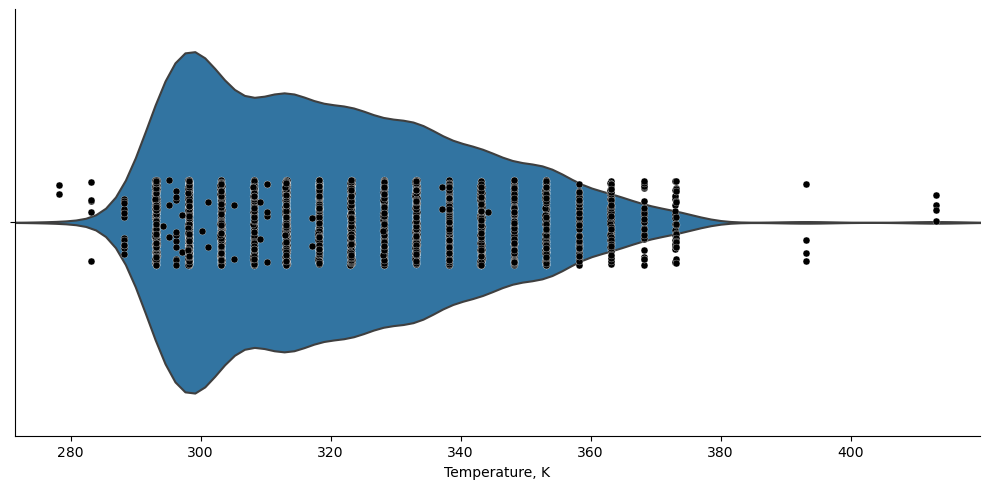

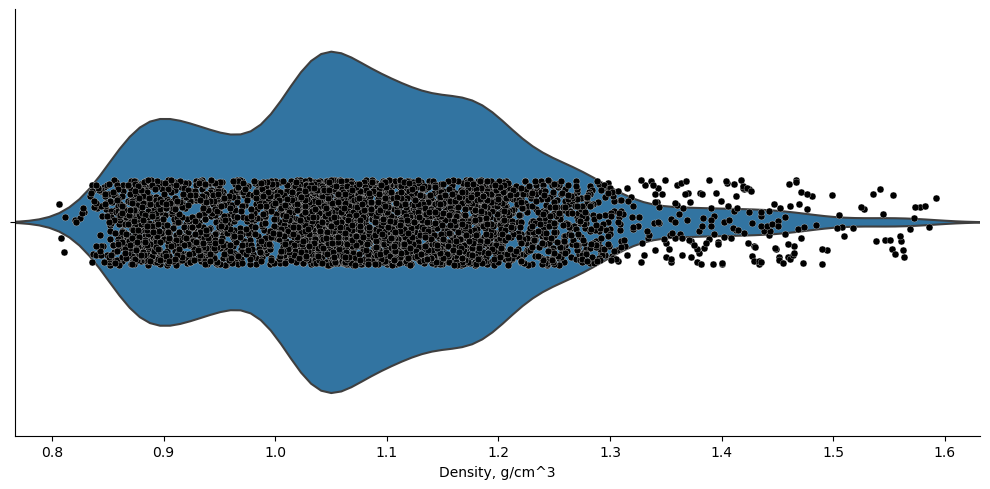

In [46]:
some_columns = ['Temperature, K', 'Density, g/cm^3']
for i in some_columns:
  try:
    g = sns.catplot(
        x=i,
        data=df,
        aspect=2,
        inner=None,
        kind='violin')
    sns.stripplot(
      x=f'{i}',
      data=df,
      color='k',
      linewidth=0.2,
      edgecolor='white',
      ax=g.ax);
  except:
    print(f'Ошибка в {i}')